In [207]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import CustomGenerator

In [214]:
import importlib
importlib.reload(CustomGenerator)
from CustomGenerator import ReturnsDataGen, CodeBookDataGen

In [100]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)
data.shape

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


(189, 250, 363)

In [3]:
data_gen = ReturnsDataGen(data)

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


In [4]:
type(data[0,0,0])

numpy.float64

In [5]:
x = data[0,:,0]
x = np.expand_dims(x, axis=1)
x.shape

(250, 1)

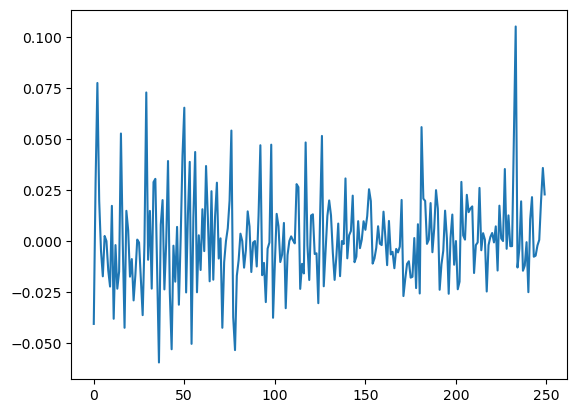

In [6]:
plt.plot(x)

In [7]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [8]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(250, 1), name='encoder_input')
    x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="valid", name='conv1d_1')(
        encoder_inputs
    )
    x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same", name='conv1d_2')(x)
    encoder_outputs = layers.Conv1D(latent_dim, 1, padding="same", name='conv1d_3')(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:], name='decoder_input')
    x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same", output_padding =1, name='conv1d_tr_1')(
        latent_inputs
    )
    x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="valid",output_padding =1, name='conv1d_tr_2')(x)
    decoder_outputs = layers.Conv1DTranspose(1, 3, padding="same", name='conv1d_tr_3')(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [9]:
encoder = get_encoder()
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 250, 1)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 32)           128       
                                                                 
 conv1d_2 (Conv1D)           (None, 62, 64)            6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 62, 16)            1040      
                                                                 
Total params: 7376 (28.81 KB)
Trainable params: 7376 (28.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-07-17 01:23:03.586962: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-17 01:23:03.586997: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-17 01:23:03.587003: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-17 01:23:03.587039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-17 01:23:03.587058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
decoder = get_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 62, 16)]          0         
                                                                 
 conv1d_tr_1 (Conv1DTranspo  (None, 124, 64)           3136      
 se)                                                             
                                                                 
 conv1d_tr_2 (Conv1DTranspo  (None, 250, 32)           6176      
 se)                                                             
                                                                 
 conv1d_tr_3 (Conv1DTranspo  (None, 250, 1)            97        
 se)                                                             
                                                                 
Total params: 9409 (36.75 KB)
Trainable params: 9409 (36.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [11]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(250, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 encoder (Functional)        (None, 62, 16)            7376      
                                                                 
 vector_quantizer (VectorQu  (None, 62, 16)            1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 250, 1)            9409      
                                                                 
Total params: 17809 (69.57 KB)
Trainable params: 17809 (69.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)

        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) 
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [13]:
vqvae_trainer = VQVAETrainer(latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(data_gen, epochs=30, batch_size=128)

Epoch 1/30


2023-07-17 01:23:12.375589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 6s 24ms/step - loss: 3.0136e-04 - reconstruction_loss: 2.0633e-04 - vqvae_loss: 6.7147e-05
Epoch 2/30
189/189 [==============================] - 4s 23ms/step - loss: 5.2341e-04 - reconstruction_loss: 1.1672e-04 - vqvae_loss: 3.8759e-04
Epoch 3/30
189/189 [==============================] - 4s 23ms/step - loss: 7.1487e-04 - reconstruction_loss: 1.2914e-04 - vqvae_loss: 5.8353e-04
Epoch 4/30
189/189 [==============================] - 4s 23ms/step - loss: 0.0016 - reconstruction_loss: 2.8621e-04 - vqvae_loss: 0.0012
Epoch 5/30
189/189 [==============================] - 4s 23ms/step - loss: 3.7934e-04 - reconstruction_loss: 5.7088e-05 - vqvae_loss: 3.1798e-04
Epoch 6/30
189/189 [==============================] - 4s 23ms/step - loss: 0.0034 - reconstruction_loss: 5.6424e-04 - vqvae_loss: 0.0028
Epoch 7/30
189/189 [==============================] - 4s 23ms/step - loss: 7.2637e-04 - reconstruction_loss: 1.0979e-04 - vqvae_loss: 6.0946e-04
Epoch 8/30
1

In [17]:
vqvae_trainer.history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'vqvae_loss'])

In [20]:
loss = vqvae_trainer.history.history['loss']
reconstruction_loss= vqvae_trainer.history.history['reconstruction_loss']
vqvae_loss = vqvae_trainer.history.history['vqvae_loss']


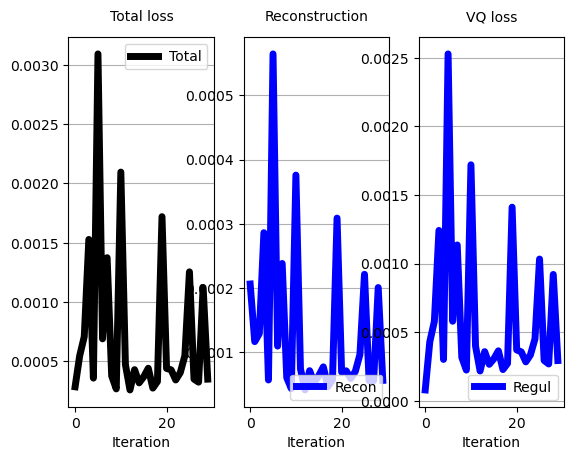

In [25]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

x_points = np.arange(0, len(loss), 1)
axes[0].set_title("Total loss", fontsize=10, y=1.022)
axes[0].plot(x_points, loss, color="black", label="Total", linewidth=5)
axes[0].yaxis.grid(True, zorder=0)
axes[0].set_xlabel('Iteration', fontsize=10)
axes[0].legend(loc='upper right')

axes[1].set_title("Reconstruction", fontsize=10, y=1.022)
axes[1].plot(x_points, reconstruction_loss, color="blue", label="Recon", linewidth=5)
axes[1].yaxis.grid(True, zorder=0)
axes[1].set_xlabel('Iteration', fontsize=10)
axes[1].legend(loc='lower right')

axes[2].set_title("VQ loss", fontsize=10, y=1.022)
axes[2].plot(x_points, vqvae_loss, color="blue", label="Regul", linewidth=5)
axes[2].yaxis.grid(True, zorder=0)
axes[2].set_xlabel('Iteration', fontsize=10)
axes[2].legend(loc='lower right')

plt.show()      

In [ ]:
trained_vqvae_model = vqvae_trainer.vqvae

(250, 363)
(363, 250)
(363, 250, 1)
12/12 [==============================] - 0s 11ms/step
(363, 250, 1)


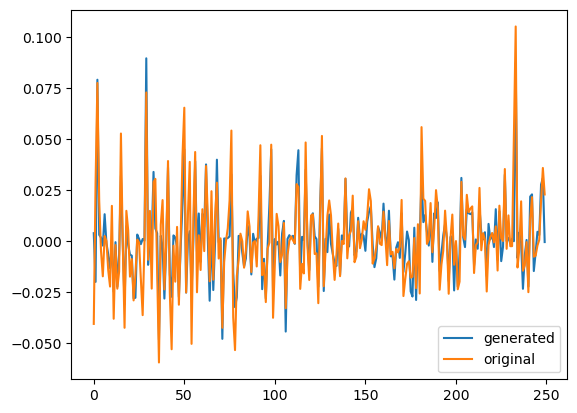

In [60]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)
trained_vqvae_model = vqvae_trainer.vqvae
x_hat = trained_vqvae_model.predict(batch)
print(x_hat.shape)
plt.plot(x_hat[0, :], label='generated')
plt.plot(batch[0, :], label='original')
plt.legend()
plt.show()

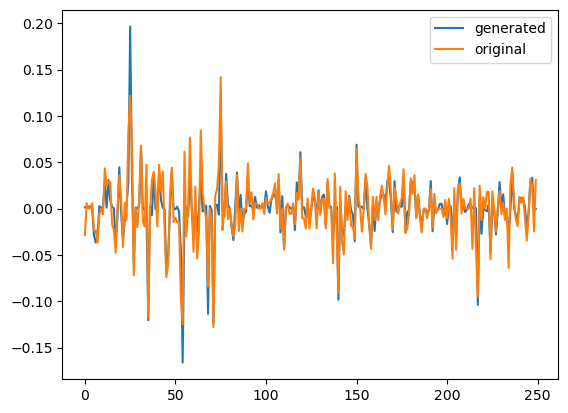

In [31]:
plt.plot(x_hat[30, :], label='generated')
plt.plot(batch[30, :], label='original')
plt.legend()
plt.show()

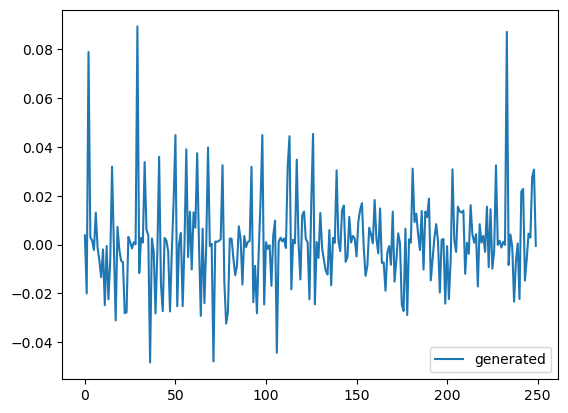

In [28]:
plt.plot(x_hat[0, :], label='generated')
plt.legend()
plt.show()

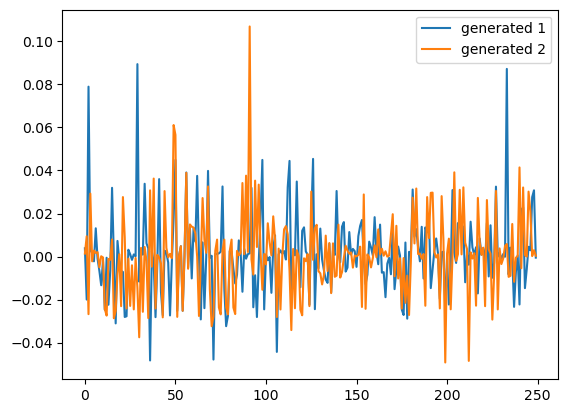

In [29]:
plt.plot(x_hat[0, :], label='generated 1')
plt.plot(x_hat[40, :], label='generated 2')
plt.legend()
plt.show()

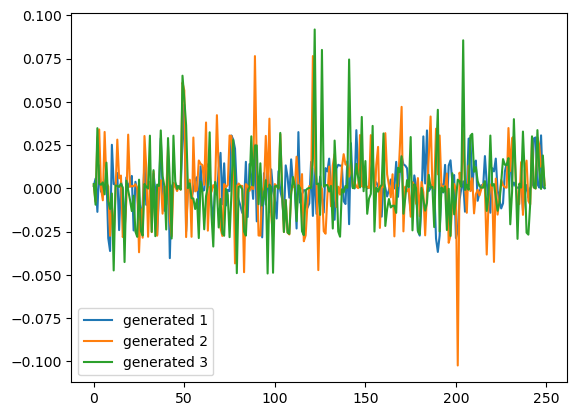

In [30]:
plt.plot(x_hat[20, :], label='generated 1')
plt.plot(x_hat[10, :], label='generated 2')
plt.plot(x_hat[100, :], label='generated 3')
# plt.plot(x_hat[0, :], label='generated 5')
# plt.plot(x_hat[40, :], label='generated 6')
plt.legend()
plt.show()

In [178]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)


(250, 363)
(363, 250)
(363, 250, 1)


12/12 [==============================] - 0s 2ms/step


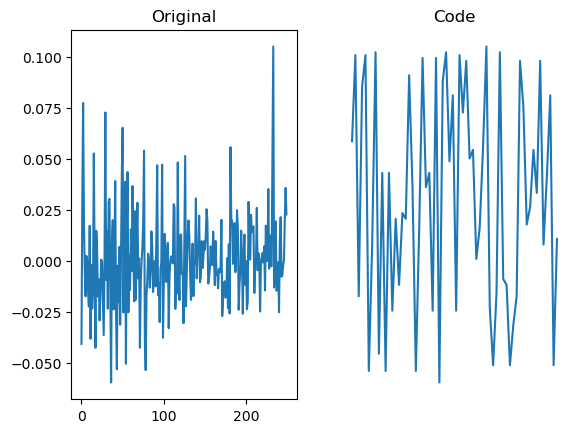

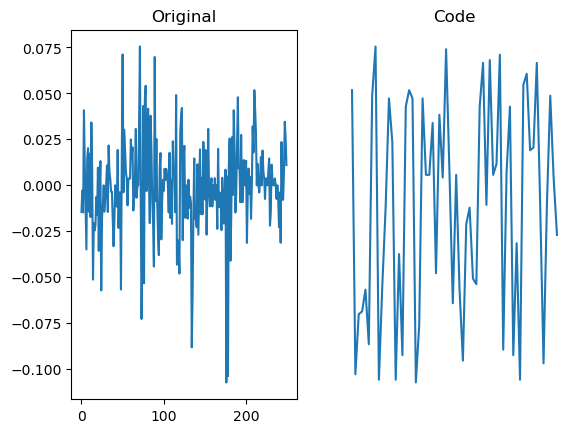

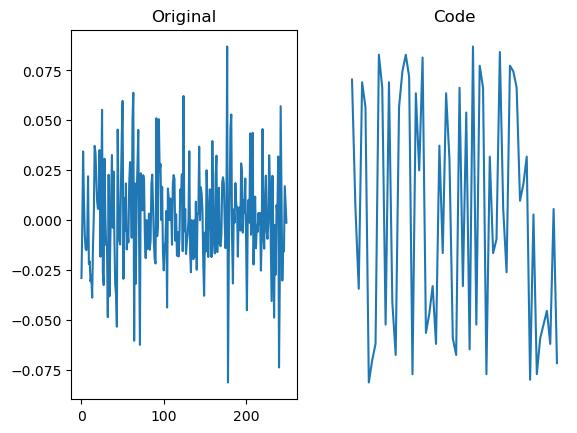

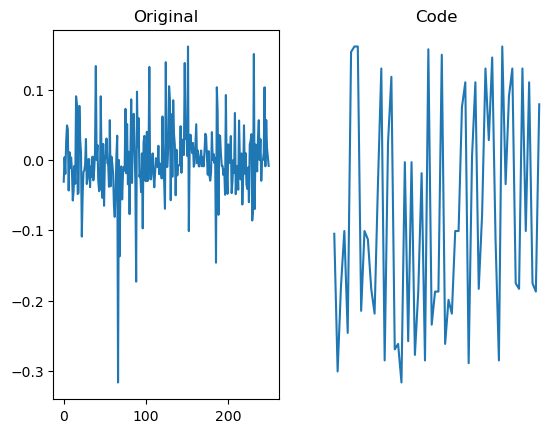

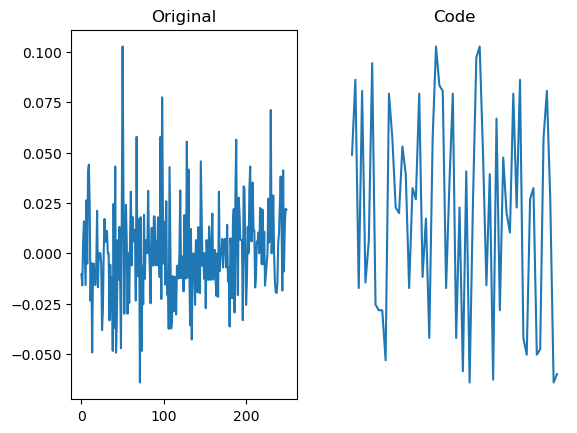

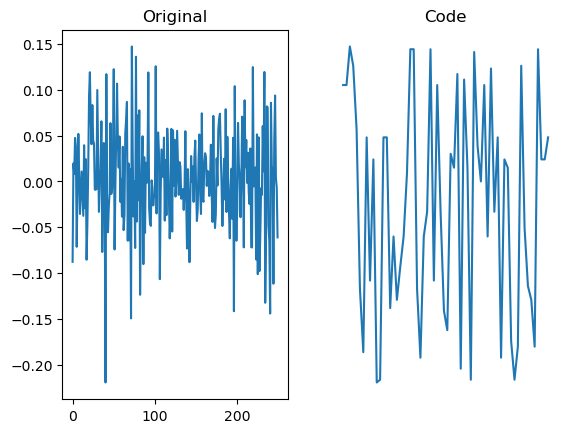

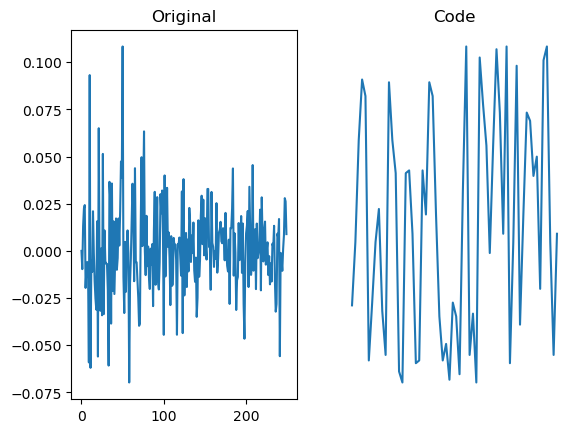

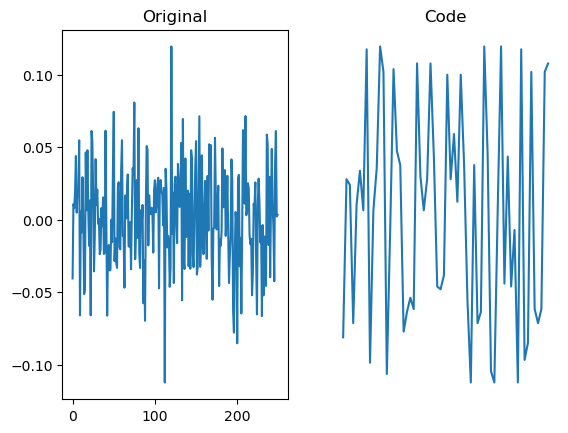

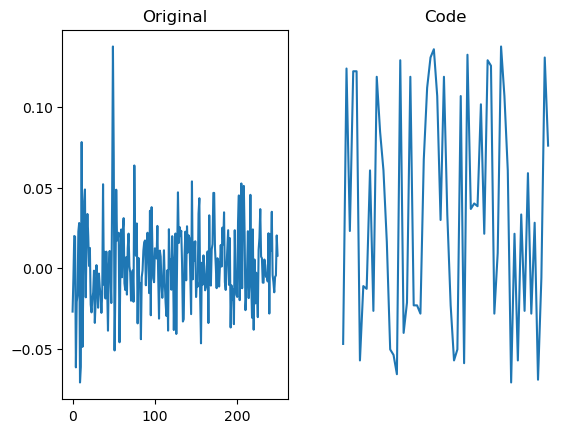

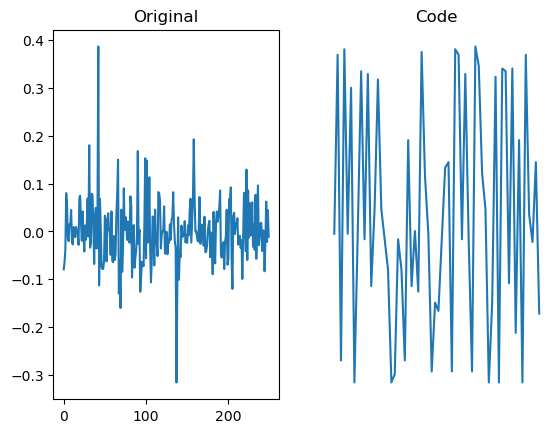

In [179]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(batch)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(10):
    plt.subplot(1, 2, 1)
    plt.plot(batch[i] )
    plt.title("Original")
    # plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.plot(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

# Sampling

In [238]:
encoded_outputs.shape

(363, 62, 16)

In [239]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (62,)


In [263]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv1D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv1D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv1D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv1D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 62)]              0         
                                                                 
 tf.one_hot_11 (TFOpLambda)  (None, 62, 128)           0         
                                                                 
 pixel_conv_layer_51 (Pixel  (None, 62, 128)           114816    
 ConvLayer)                                                      
                                                                 
 residual_block_20 (Residua  (None, 62, 128)           49472     
 lBlock)                                                         
                                                                 
 residual_block_21 (Residua  (None, 62, 128)           49472     
 lBlock)                                                         
                                                         

In [241]:
batch= data[0]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
batch= np.expand_dims(batch, axis=2)
print(batch.shape)

(250, 363)
(363, 250)
(363, 250, 1)


In [242]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(batch)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(codebook_indices.shape)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

12/12 [==============================] - 0s 3ms/step
(363, 62, 16)
(22506, 16)
(22506,)
Shape of the training data for PixelCNN: (363, 62)


In [195]:
codebook_indices_all = np.empty((train_batches, stocks , 62 ))
codebook_indices_all.shape

(189, 363, 62)

In [196]:
for i, batch in enumerate(data): 
    # b= np.empty((stocks , length ))
    batch= np.transpose(batch)
    
    batch= np.expand_dims(batch, axis=2)
    encoded_outputs_all = encoder.predict(batch)
    flat_enc_outputs = encoded_outputs_all.reshape(-1, encoded_outputs_all.shape[-1])

    codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

    codebook_indices_all[i,:, :] = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
    

12/12 [==============================] - 0s 6ms/step


In [203]:
codebook_indices_all.shape

(189, 363, 62)

In [205]:
codebook_indices_all[0].shape

(363, 62)

In [204]:
codebook_indices.shape

(363, 62)

codebook_indices_all = codebook_indices_all.reshape(-1, codebook_indices_all.shape[-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices_all.shape}")

In [215]:
codebook_gen = CodeBookDataGen(codebook_indices_all)

Number of training batches:  189
Number of stocks:  363
Number of latent variables:  62


In [264]:
pixel_cnn.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=128,
    epochs=30,
    validation_split=0.1)

Epoch 1/30


2023-07-17 14:01:25.439612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 4.8510 - accuracy: 0.0128

2023-07-17 14:01:26.823153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 507ms/step - loss: 4.8510 - accuracy: 0.0128 - val_loss: 4.8488 - val_accuracy: 0.0131
Epoch 2/30
3/3 [==============================] - 0s 105ms/step - loss: 4.8473 - accuracy: 0.0165 - val_loss: 4.8449 - val_accuracy: 0.0166
Epoch 3/30
3/3 [==============================] - 0s 113ms/step - loss: 4.8429 - accuracy: 0.0181 - val_loss: 4.8399 - val_accuracy: 0.0166
Epoch 4/30
3/3 [==============================] - 0s 132ms/step - loss: 4.8373 - accuracy: 0.0180 - val_loss: 4.8335 - val_accuracy: 0.0170
Epoch 5/30
3/3 [==============================] - 0s 73ms/step - loss: 4.8300 - accuracy: 0.0180 - val_loss: 4.8246 - val_accuracy: 0.0174
Epoch 6/30
3/3 [==============================] - 0s 101ms/step - loss: 4.8198 - accuracy: 0.0180 - val_loss: 4.8122 - val_accuracy: 0.0174
Epoch 7/30
3/3 [==============================] - 0s 49ms/step - loss: 4.8055 - accuracy: 0.0180 - val_loss: 4.7946 - val_accuracy: 0.0174
Epoch 8/30
3/3 [=================

In [265]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [266]:
priors.shape

(10, 62)

In [267]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):

    # Feed the whole array and retrieving the pixel value probabilities for the next
    # pixel.
    probs = sampler.predict(priors)
    # Use the probabilities to pick pixel values and append the values to the priors.
    priors[:, row] = probs[:, row]

print(f"Prior shape: {priors.shape}")

2023-07-17 14:01:44.045821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 21ms/step
Prior shape: (10, 62)


In [268]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)



1/1 [==============================] - 0s 18ms/step


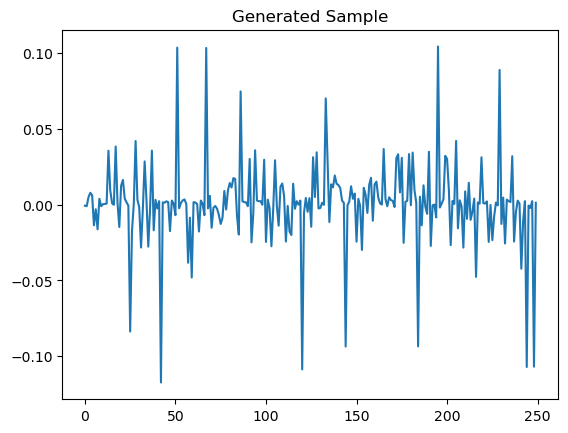

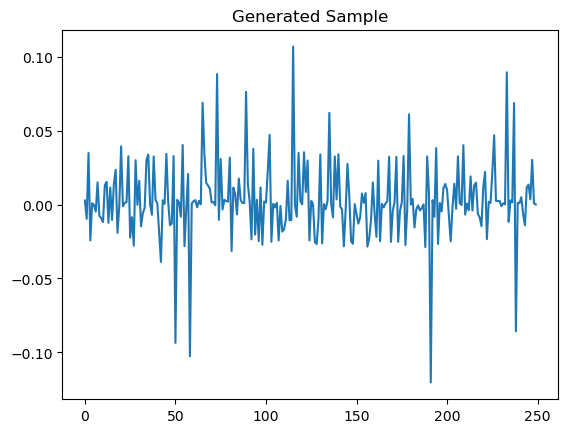

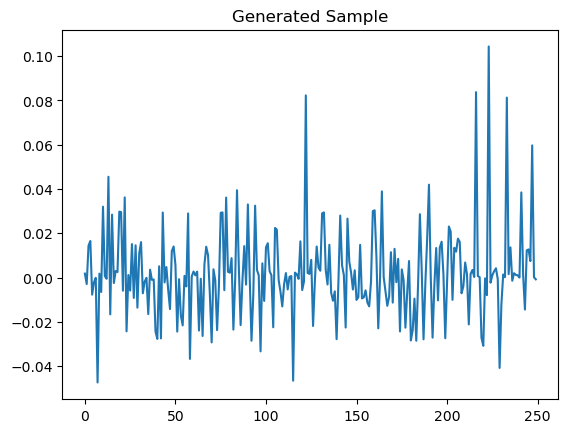

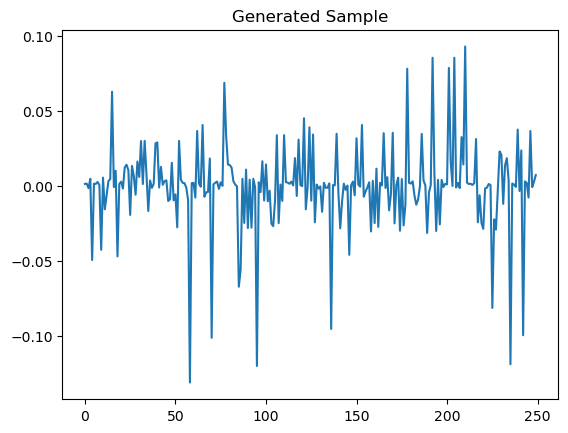

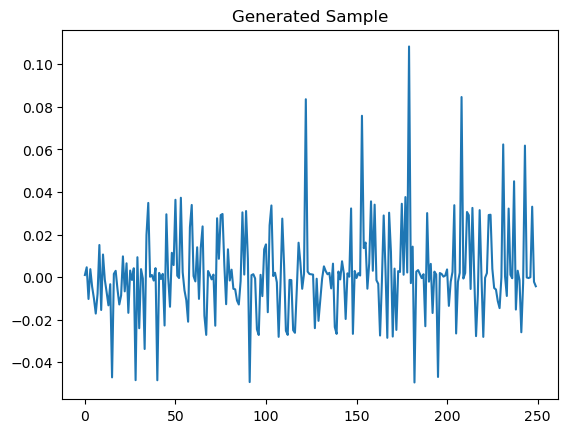

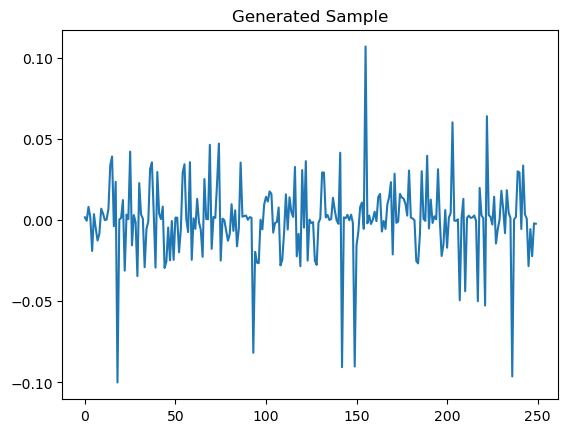

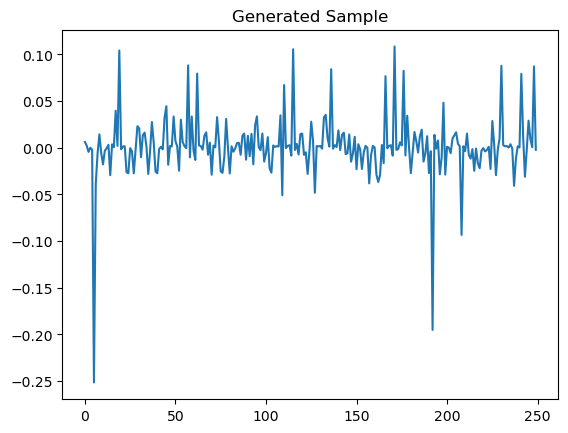

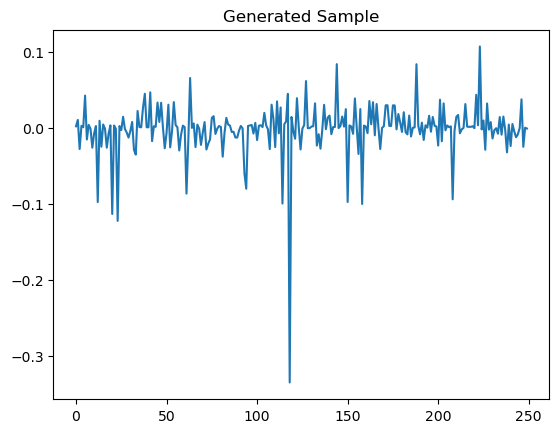

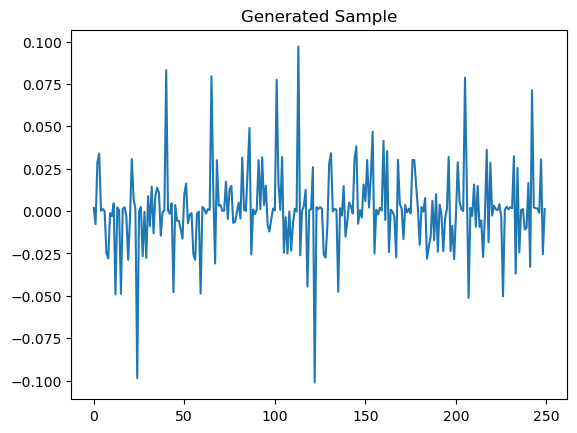

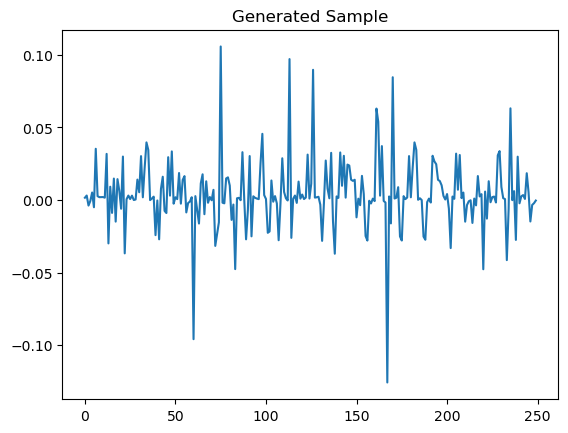

In [269]:
for i in range(batch):

    plt.plot(generated_samples[i])
    plt.title("Generated Sample")

    plt.show()